In [ ]:
!pip install mlxtend scipy networkx

# **Step 1: Load Data**
Uploaded the necessary files (Books_cleaned.xlsx, Ratings.xlsx, Users.xlsx),can read them into Pandas DataFrames:

In [4]:
import pandas as pd
import warnings
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx

warnings.filterwarnings("ignore", category=DeprecationWarning)


books_df = pd.read_excel("/content/Books_cleaned.xlsx", engine='openpyxl')  # Ensure closing quotation mark
ratings_df = pd.read_excel("/content/Ratings.xlsx", engine='openpyxl')
users_df = pd.read_excel("/content/Users.xlsx", engine='openpyxl')




# **Step 2: Data Cleaning and Preparation**
Ensure your data is clean, with correct data types, no duplicates, and missing values handled:

python


In [5]:

books_df.drop_duplicates(inplace=True)
ratings_df.drop_duplicates(inplace=True)
users_df.drop_duplicates(inplace=True)

ratings_df.fillna({'Book-Rating': 0}, inplace=True)

books_df['Year-Of-Publication'] = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce')
ratings_df['User-ID'] = ratings_df['User-ID'].astype(int)


# **Step 3: Apply Data Reduction and Transaction Encoding**
Reduce the data to focus on relevant information and encode transactions for analysis:

In [9]:

min_transactions = 5

filtered_ratings_df = ratings_df[ratings_df.groupby("User-ID")["ISBN"].transform("count") >= min_transactions]

user_transactions = filtered_ratings_df.groupby("User-ID")["ISBN"].apply(list)


In [13]:

user_transactions_cleaned = user_transactions.apply(lambda x: [str(item) for item in x if isinstance(item, str)])  # Ensure strings only

te = TransactionEncoder()
transformed = te.fit(user_transactions_cleaned).transform(user_transactions_cleaned)



In [14]:

filtered_ratings_df = filtered_ratings_df.dropna(subset=["ISBN"])  # Drop rows with NaN in "ISBN"
filtered_ratings_df["ISBN"] = filtered_ratings_df["ISBN"].astype(str)  # Convert all ISBNs to strings


In [15]:

user_transactions_cleaned = filtered_ratings_df.groupby("User-ID")["ISBN"].apply(lambda x: list(set(x)))  # Ensure unique ISBNs and strings only

te = TransactionEncoder()
transformed = te.fit(user_transactions_cleaned).transform(user_transactions_cleaned)
sparse_df = csr_matrix(transformed)

transaction_df = pd.DataFrame.sparse.from_spmatrix(sparse_df, columns=te.columns_)


# **Step 4: Apply FP-Growth and Generate Association Rules**
Generate frequent itemsets using the FP-Growth algorithm and association rules with a specified metric and threshold:

In [16]:

frequent_itemsets = fpgrowth(transaction_df, min_support=0.01, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

isbn_to_title = books_df.set_index('ISBN')['Book-Title'].to_dict()

def map_isbn_to_title(itemset):
    return [isbn_to_title.get(isbn, isbn) for isbn in itemset]

frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(map_isbn_to_title)
rules['antecedents'] = rules['antecedents'].apply(map_isbn_to_title)
rules['consequents'] = rules['consequents'].apply(map_isbn_to_title)


# **Step 5: Top 50 Books by Average Rating**

In [33]:

books_df['ISBN'] = books_df['ISBN'].str.replace(r'\D', '').astype(str)
ratings_df['ISBN'] = ratings_df['ISBN'].str.replace(r'\D', '').astype(str)

missing_isbns = set(ratings_df['ISBN']) - set(books_df['ISBN'])



Missing ISBNs: {'834107694', '3548240615', '3548027199', '4431396414', '8804366419', '72511709', '6754279', '9100100544', '340335726', '771084404', '590427563', '600570967', '2266000314', '912696737', '99430967', '2171090', '751508594', '31227796', '8475743013', '8880913395', '708819729', '6493122', '35520502054', '751505595', '8526219278', '9530603231', '552132640', '6545793', '3596145872', '590526510', '3453099575', '3596133963', '3933103118', '8493189375', '747261741', '4686171118', '3404242025', '8460775909', '340703814', '3257700865', '771058837', '3401016032', '059030237X', '3505044504', '8809017528', '1856862216', '044923052X', '8425335620', '61103601', '3451266261', '9029048360', '811441571', '8842261488X', '3888970547', '8881123851', '670896489', '9728298145', '3492116167', '439326982', '739419994', '330257617', '670851272', '3453542487', '1843090422', '9876543210', '3499143615', '3442424887', '44041668', '330250809', '21041972001', '9041704841', '67181740', '99276976', '84825

In [36]:


books_df['ISBN'] = books_df['ISBN'].str.replace(r'\D', '').astype(str)
ratings_df['ISBN'] = ratings_df['ISBN'].str.replace(r'\D', '').astype(str)

average_ratings = ratings_df.groupby('ISBN')['Book-Rating'].mean()

top_50_books = average_ratings.nlargest(50)

top_50_books_with_titles = top_50_books.reset_index().merge(books_df[['ISBN', 'Book-Title']], on='ISBN', how='left')

# Exclude rows where the book title is NaN
top_50_books_with_titles_cleaned = top_50_books_with_titles.dropna(subset=['Book-Title'])

# Display the top 50 books with book titles
print(top_50_books_with_titles_cleaned[['ISBN', 'Book-Title', 'Book-Rating']])




          ISBN                                         Book-Title  Book-Rating
4   000225056X                  The International Garlic Cookbook         10.0
5   000255755X  Come Through Marjorie's Garden Gate: Spend a Y...         10.0
6   000599134X                             Collins Bible Handbook         10.0
9   000639194X                                           Firewing         10.0
11  000648185X                          Escape from the Big Muddy         10.0
12  000673765X                                        Apple Bough         10.0
13  000692347X  The Clue of the Broken Locket (The Nancy Drew ...         10.0
14  000710331X                                              Tarot         10.0
15  000710698X                        Pagan Pathways, New Edition         10.0
16  000711365X  Central Fells: Lakeland Fellranger (Lakeland F...         10.0
18  000715111X  The Real Witches Book of Spells and Rituals (R...         10.0
20  002011690X  Complete How-To Book of Indiancraft:

# **Step 6: Visualize Association Rules with NetworkX**
Create a directed graph to visualize association rules, with nodes representing books and edges representing relationships with edge weights:

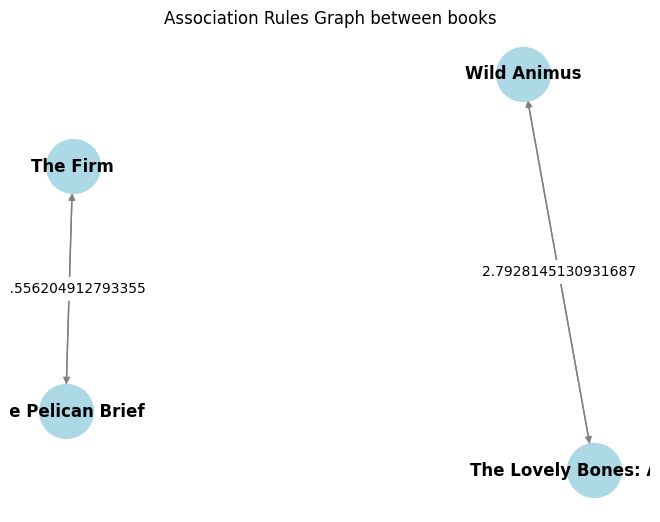

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()

for _, rule in rules.iterrows():
    antecedent = list(rule['antecedents'])[0]
    consequent = list(rule['consequents'])[0]
    lift = rule['lift']

    if not graph.has_node(antecedent):
        graph.add_node(antecedent)
    if not graph.has_node(consequent):
        graph.add_node(consequent)

    graph.add_edge(antecedent, consequent, weight=lift)

pos = nx.spring_layout(graph, k=3.0)

nx.draw(
    graph,
    pos,
    with_labels=True,
    node_color='lightblue',
    font_weight='bold',
    edge_color='grey',
    node_size=1500,
    font_size=12,
)

edge_labels = nx.get_edge_attributes(graph, 'weight')


nx.draw_networkx_edge_labels(
    graph,
    pos,
    edge_labels=edge_labels,
    font_size=10,
    rotate=False,
    label_pos=0.5
)

plt.title("Association Rules Graph between books")
plt.show()




# **Step 7: Apply KNN for Nearest Book Recommendations**
Apply K-Nearest Neighbors to find nearest book recommendations based on feature vectors:

In [25]:

book_features = np.array([
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 0]
])

knn = NearestNeighbors(n_neighbors=2)
knn.fit(book_features)

query = np.array([[1, 1, 0]])
distances, indices = knn.kneighbors(query)

print("Nearest books based on KNN:")
print(indices)


Nearest books based on KNN:
[[2 1]]


# **Step 8: Data Visualization**

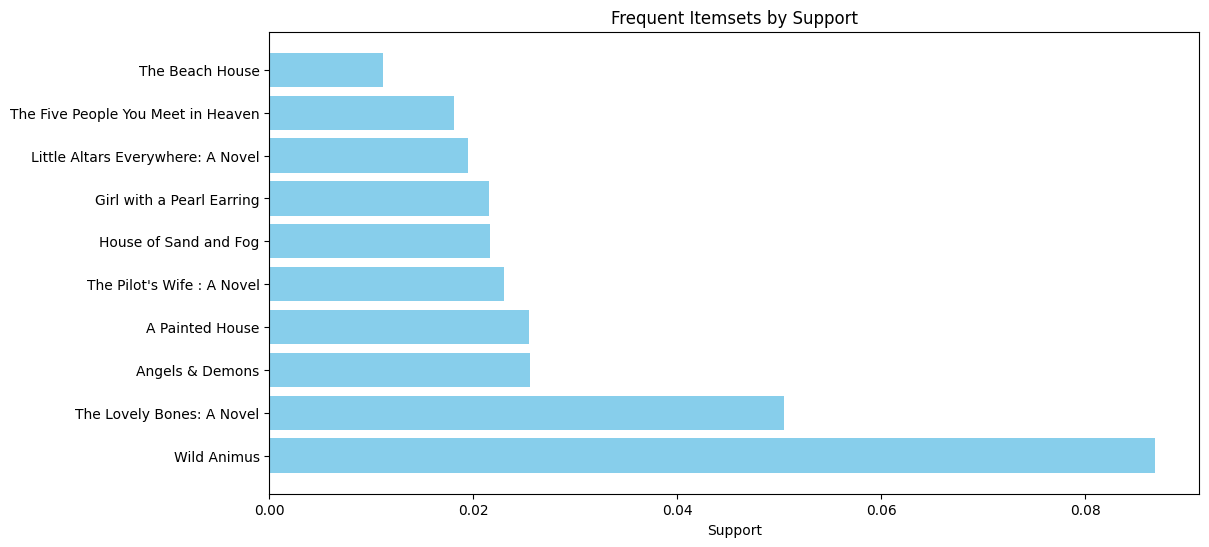

In [27]:
import matplotlib.pyplot as plt


frequent_itemsets = pd.DataFrame({
    'support': [0.0180741503604531, 0.0255406797116375, 0.0111225540679712, 0.0195159629248198,
                0.0868692070030896, 0.0505149330587024, 0.025437693099897, 0.0229660144181257,
                0.0216786817713697, 0.0215756951596293],
    'itemsets': [['The Five People You Meet in Heaven'], ['Angels & Demons'], ['The Beach House'],
                 ['Little Altars Everywhere: A Novel'], ['Wild Animus'], ['The Lovely Bones: A Novel'],
                 ['A Painted House'], ["The Pilot's Wife : A Novel"], ['House of Sand and Fog'],
                 ['Girl with a Pearl Earring']]
})

frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)

# Plotting the bar plot
plt.figure(figsize=(12, 6))
plt.barh([' | '.join(itemset) for itemset in frequent_itemsets['itemsets']], frequent_itemsets['support'], color='skyblue')
plt.xlabel('Support')
plt.title('Frequent Itemsets by Support')
plt.show()


# **Step 9: Export Results for Further Analysis**
Export results to Excel for further analysis or sharing:

In [26]:

with pd.ExcelWriter("book_recommendations.xlsx") as writer:
    frequent_itemsets.to_excel(writer, sheet_name="Frequent Itemsets", index=False)
    rules.to_excel(writer, sheet_name="Association Rules", index=False)

# Download the Excel file from Colab
from google.colab import files
files.download("book_recommendations.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>